In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# add image size as feature
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 
# lgbm eval rmsle instead of rmse


In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Old cleanup function(for testing purposes)

In [7]:
BlackHighThreshold = 0.1 # the definition of 'black' to determine the radius of a non galaxy object, in luminance
PeakExclusionRadius = 0.1 # the radius around the center within which we ignore luminosity peaks, expressed as an image percentage
NonClearingRadius = 0.1 # the radius around the center within which we don't clean (even with peaks outside)
ObjectLuminosityPercentage = 0.7 # the peak luminosity threshold that we remove points around, expressed as a percentage of the peak center luminosity
valueWhenRemovingPixel = 0 # -55 when debugging, 0 when running

def removeNegs(na):
    for i in range(len(na)):
        for j in range(len(na)):
            na[i][j] = max(0,na[i][j])

    return na

def normalizeInt(na):
    ma = np.amax(na)
    mi = np.amin(na)

    na = na * (ma - mi)
    return na

def removePeakAtPosition(data, x, y, size):
    global BlackHighThreshold
    global valueWhenRemovingPixel
    imagewidth = len(data)
    center = imagewidth/2

    threshold = BlackHighThreshold #definition of "black"
    exlusionRadiusSquared = (imagewidth*PeakExclusionRadius)**2  # radius around the center where we don't remove anything
    for i in range(imagewidth):
        if (
                ( x-i >= 0 and data[x-i][y] < threshold) or
                ( x+i < imagewidth and data[x+i][y] < threshold ) or
                ( y -i >= 0 and data[x][y-i] < threshold ) or
                ( y +i < imagewidth and data[x][y+i] < threshold )
            ):
            circlesize = i
            break

    for i in range(x-circlesize, x+circlesize+1):
        for j in range(y-circlesize, y+circlesize+1):
            if ( i >= 0 and i < len(data[1]) and
                 i >= 0 and j < len(data[1]) and
                     (x-i)**2 + (y-j)**2 <= circlesize**2):
                # exlusion zone
                if ( (center-i)**2 + (center-j)**2 >= exlusionRadiusSquared ):
                    data[i][j] = valueWhenRemovingPixel

    return data

def removeAboveThreshold(na, threshold):
    global valueWhenRemovingPixel
    for i in range(len(na)):
        for j in range(len(na)):
            if ( na[i][j] > threshold ):
                na[i][j] = valueWhenRemovingPixel

    return na

def findLumCenter(na):
    center = int(len(na)/2)

    peakfound = False
    moved = False
    px = center
    py = center
    while True:
        moved = False
        for i in range(-5, 5):
            for j in range(-5, 5):
                if (na[px + i][py + j] > na[px][py]):
                    px = px + i
                    py = py + j
                    moved = True
                    break
        if (moved == False):
            peakfound = True
            break

    if (peakfound == True):
        centerLum = na[px][py]

    return centerLum

def findMaxima(na):
    global NonClearingRadius
    global ObjectLuminosityPercentage
    width = len(na)
    center = int(width / 2)

    #find lum center
    centerLum = findLumCenter(na)

    starLumThreshold = centerLum * ObjectLuminosityPercentage
    exlusionRadiusSquared = (width*NonClearingRadius)**2


    for x in range(width):
        for y in range(width):
            # find the peak:
            if na[x][y] <= starLumThreshold:
                continue
            # found a place where there's a peak. Find it
            peakfound = False
            moved = False
            px = x
            py = y
            while True:
                moved = False
                for i in range(-2,2):
                    for j in range(-2,2):
                        if ( px+i < 1 or py+j < 1 or px+i >= width or py+j >= width):
                            continue

                        if (na[px + i][py + j] > na[px][py]):
                            px = px + i
                            py = py + j
                            moved = True
                            break
                if (moved == False):
                    peakfound = True
                    break

            if (peakfound == True):
                # remove that peak
                if ((center - px) ** 2 + (center - py) ** 2 > exlusionRadiusSquared):
                    na = removePeakAtPosition(na,px,py,max(abs(py-y),abs(px-x))+1)
#            print("found", (px, py), (x, y))

    return na

def cleanupImage(na):
    na = removeNegs(na)
    na = findMaxima(na)
    na = removeAboveThreshold(na, findLumCenter(na))
    return na

# Check a few random images 


1237661064416526446.npy
1237667254010773605.npy
1237667914883072206.npy
1237661433773359260.npy
1237665129077997684.npy


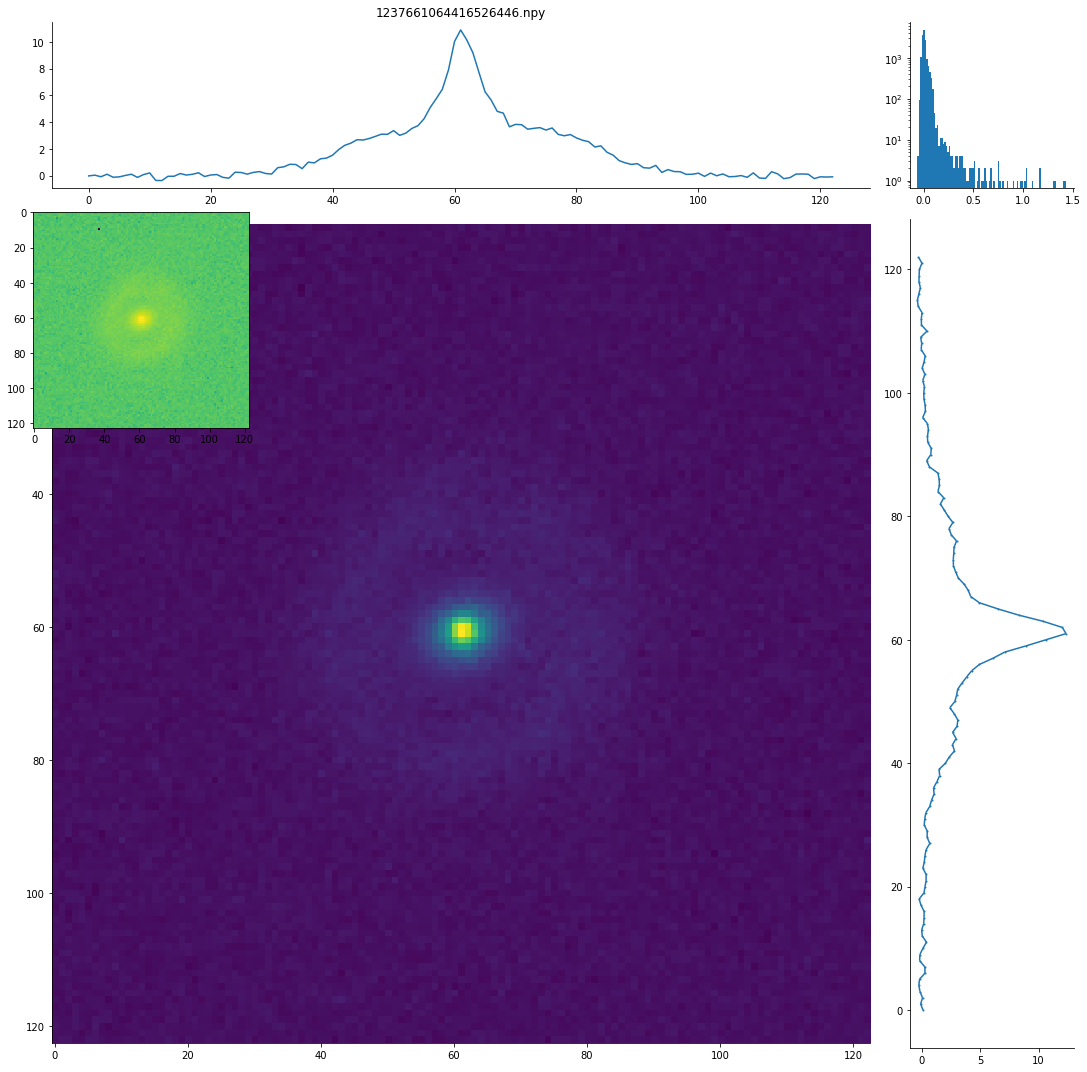

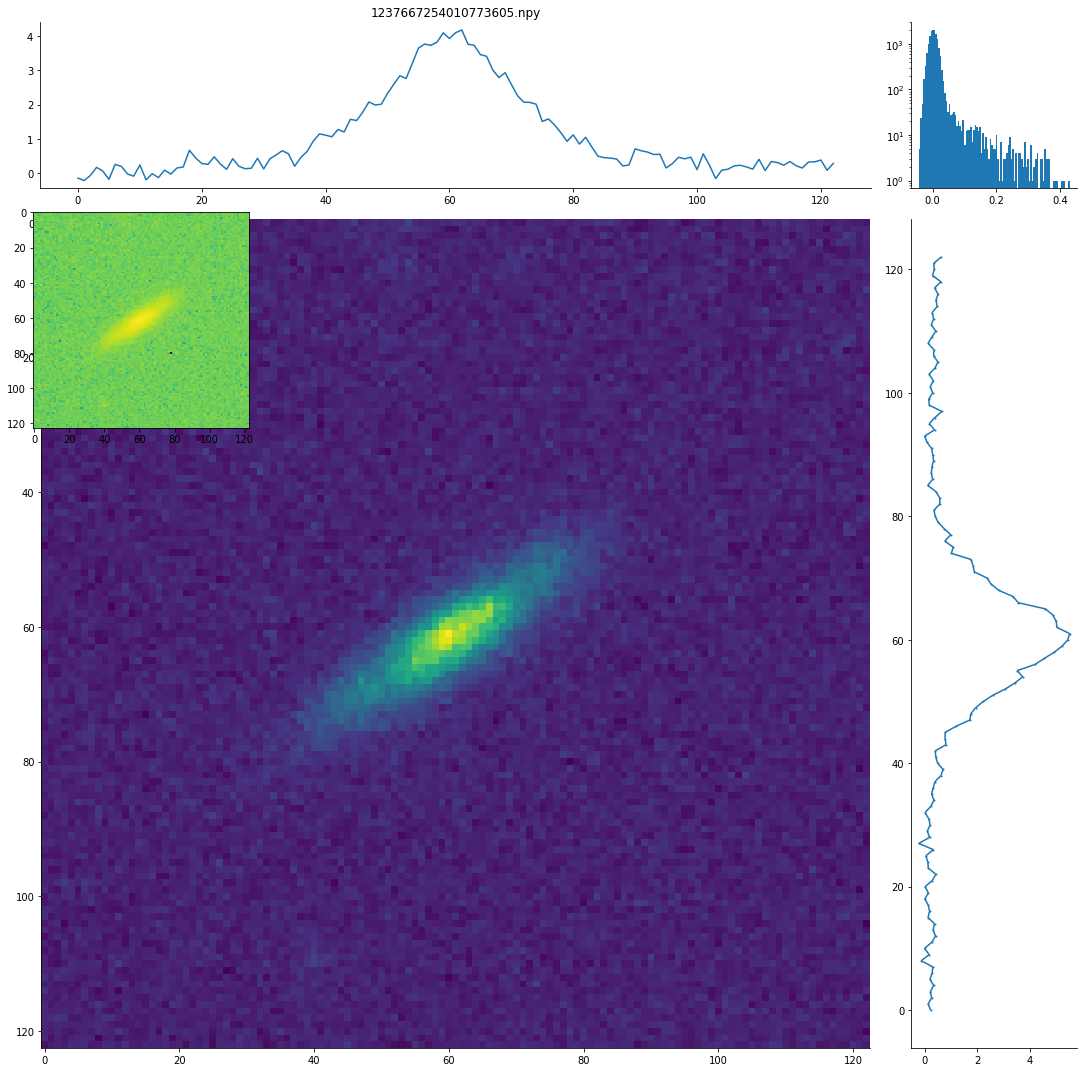

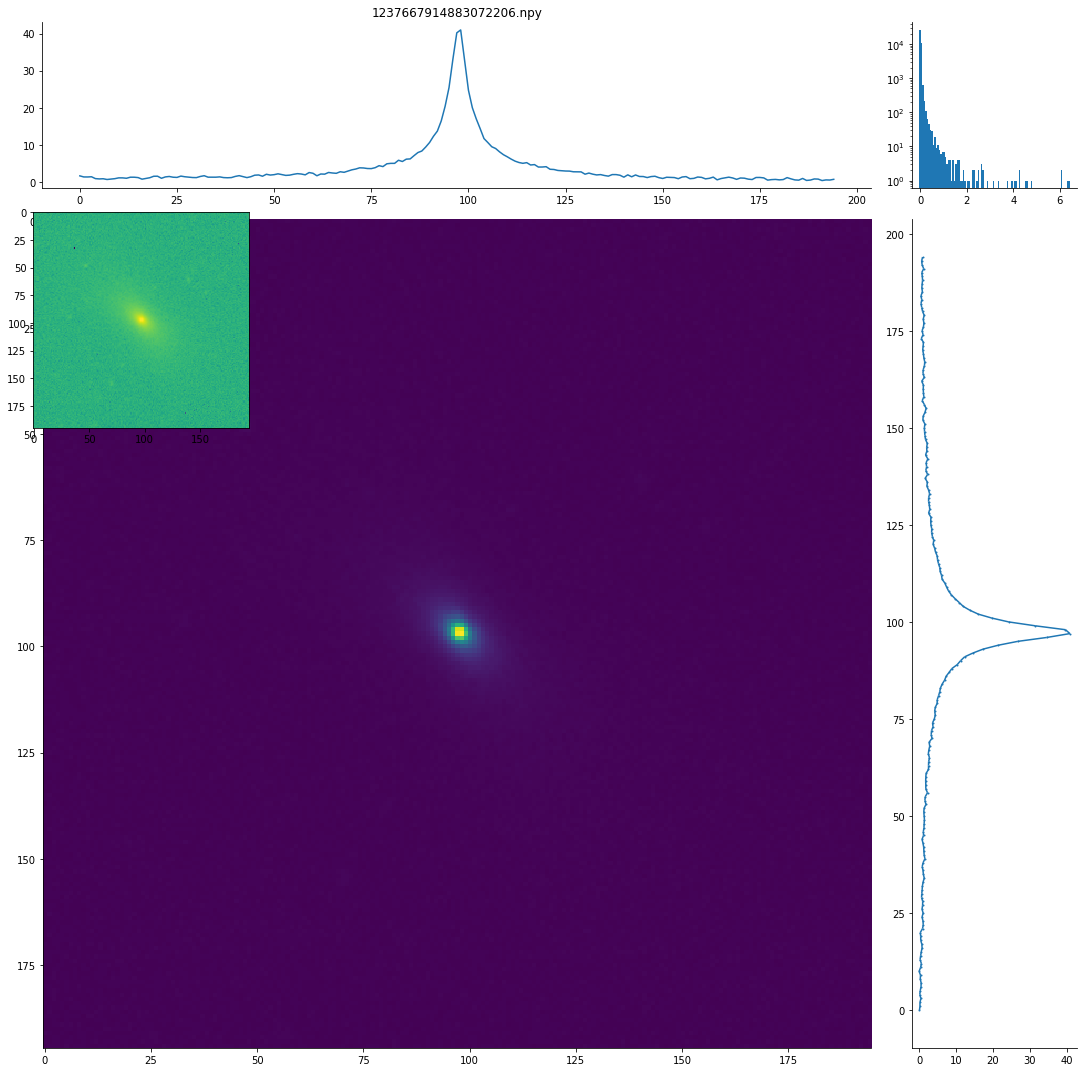

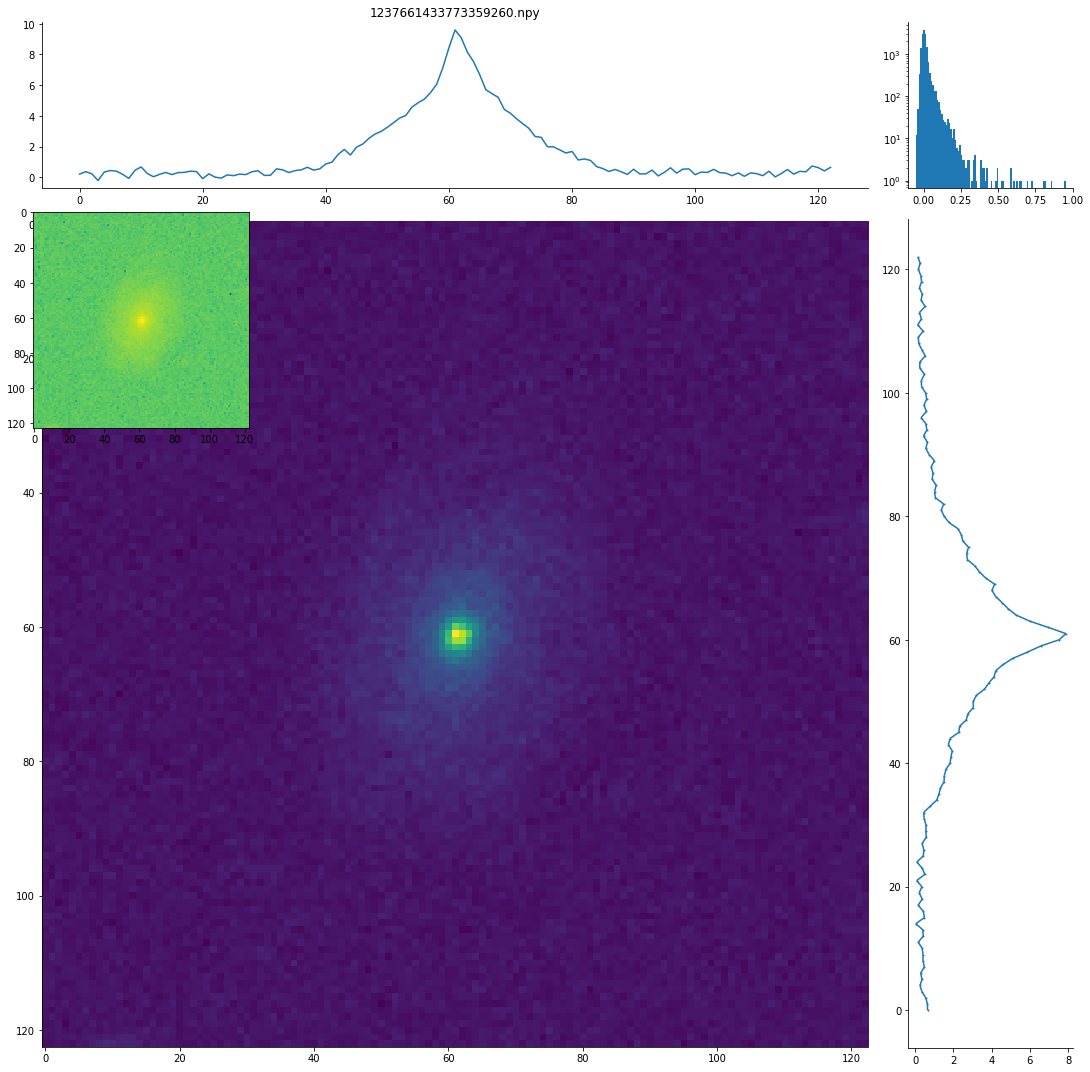

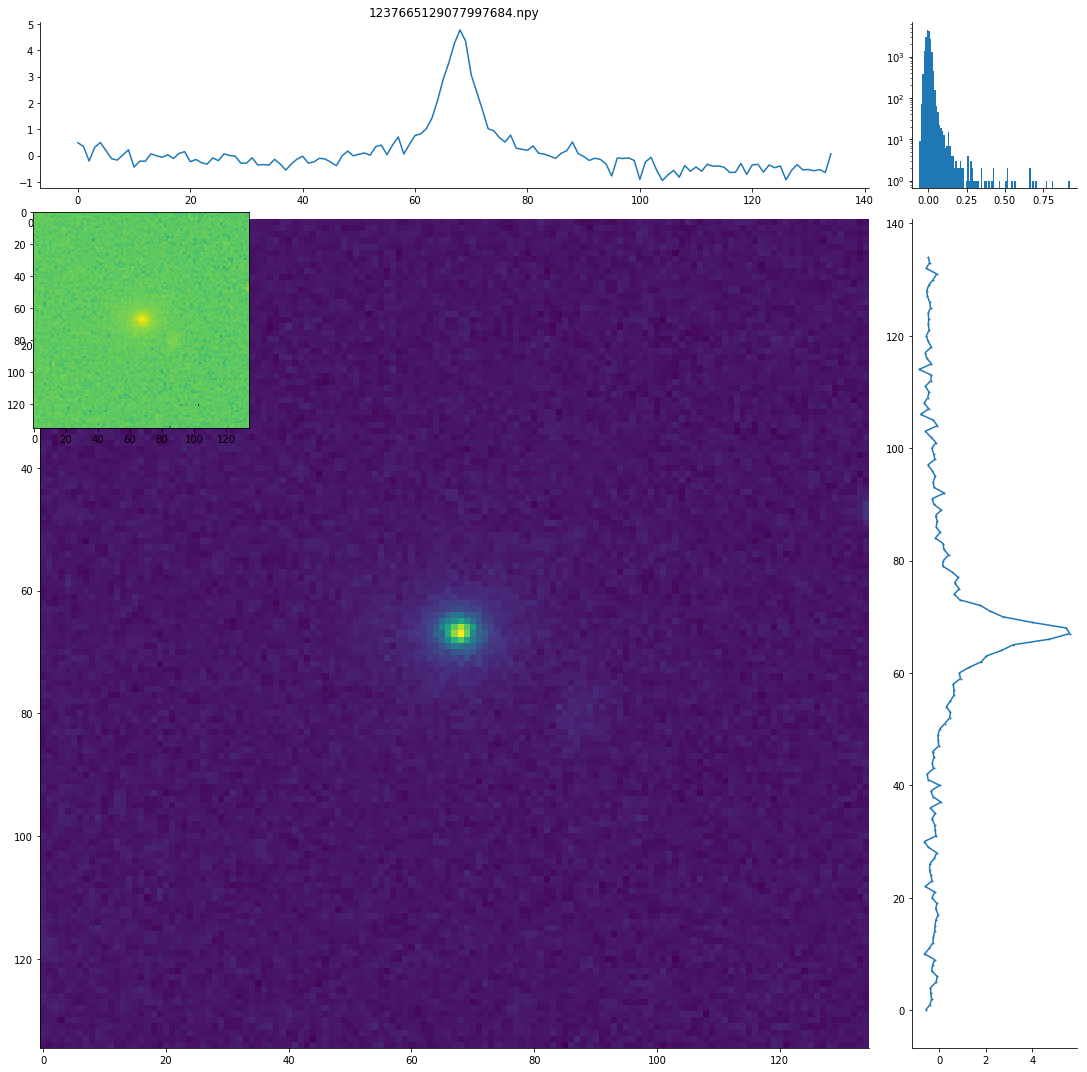

In [8]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
    drawOneGalaxy(dataFileList[i])
    


In [9]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [10]:
print('test')

test


# ML part

In [11]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [12]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = cy//2, cx//2 # crop half
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preproc(id):
    Xg = read_image(id)
#    Xg = cleanupImage(id)
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)    
    return Xgr

runNameParams.append('ReadNormCrop.5')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


-0.423504 39.9641
[[-0.18784104 -0.18784104 -0.18917809 -0.19084309 -0.19250809]
 [-0.18784104 -0.18784104 -0.18917809 -0.19084309 -0.19250809]
 [-0.19743252 -0.19743252 -0.19185182 -0.18490225 -0.17795269]
 [-0.20937662 -0.20937662 -0.19518135 -0.17750423 -0.15982711]
 [-0.22132073 -0.22132073 -0.1985109  -0.1701062  -0.14170152]]


1

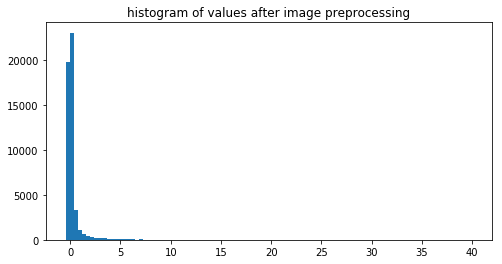

In [13]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [14]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [15]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [16]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [17]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [18]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [19]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237657610728439853,176.40375,56.18820,0.407380,0.0496,25.190166,212.5714346766472,0.412230,10.382,0.030,212.571435,2.409905e+10,1.664704e+09,True
1,1237664818753437793,191.06025,37.16728,0.478630,0.1530,91.293690,655.7142734527588,1.271597,11.438,0.022,655.714273,2.741574e+11,1.388796e+10,True
2,1237657630057693294,154.84455,49.05036,0.912011,0.0562,63.897760,240.8571488090924,0.467083,10.489,0.015,240.857149,3.083188e+10,1.064895e+09,True
3,1237665369045860362,172.82175,32.30943,0.436516,0.0422,22.964752,180.857138974326,0.350728,10.359,0.030,180.857139,2.285599e+10,1.578836e+09,True
4,1237665530643808416,227.20770,20.06000,0.933254,0.0417,48.516050,178.7142934543746,0.346573,11.076,0.026,178.714293,1.191242e+11,7.131634e+09,True


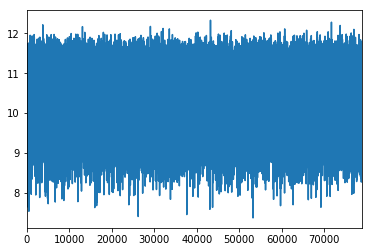

In [21]:
df.logMstar.plot()

In [22]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [23]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)
prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

chunkSize = 500
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


In [24]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [25]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78851
70965
500
sp-newSource-ReadNormCrop.5


In [26]:
crap instruction to make the auto execution stop here :p

SyntaxError: invalid syntax (<ipython-input-26-9b8943694fca>, line 1)

### call img_preproc on all images, per batches of "chunkSize" and save them to disk

In [27]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [28]:
reloadImagesAndPreprocess = 0

maxChunkNumber = math.ceil(len(ids)/chunkSize)

chunkStart = 0
for chunkStart in tqdm(range(0, len(ids), chunkSize)):
    curChunk = int((chunkStart//chunkSize))
    valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart
    fileName = chunkFileName(chunkSize, prefixThisRound, curChunk)
    if ( reloadImagesAndPreprocess == 1 or not(os.path.isfile(fileName))):
        Xg_ = []
        
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            Xg_.append(img_preproc(ids[i]))

        Xg = np.stack(Xg_)

        Xg3 = np.zeros((valuesInThisChunk,224,224,3))

        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        fileName = chunkFileName(chunkSize, prefixThisRound, curChunk)
        np.save(fileName,Xg3)

print('done')

100%|██████████| 158/158 [02:50<00:00,  1.04s/it]

done


### Generate features based on the preprocessed images, pretrained networks and flux densities

In [29]:
Xg3r50 = []
Xg3vgg16 = []
extraImgFeatures = []
csize=2

chunkStart = 0
for chunkStart in tqdm(range(0, len(ids), chunkSize)):
    curChunk = int((chunkStart//chunkSize))
    valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

    Xg3 = np.load(chunkFileName(chunkSize, prefixThisRound, curChunk))

    Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
    Xg3vgg16_ = vgg16.predict(Xg3)
    ex = np.hstack([
        np.sum(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.min(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.max(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.mean(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.std(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        Xg3[:,112,112,0].reshape(valuesInThisChunk,1),       # center
        np.mean(Xg3[:,112-csize:112+csize,112-csize:112+csize,0].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
        ])

    if chunkStart == 0:
        Xg3r50 = Xg3r50_
        Xg3vgg16 = Xg3vgg16_
        extraImgFeatures = ex
    else:
        Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
        Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
        extraImgFeatures = np.concatenate([extraImgFeatures,ex], axis=0)
        
        
extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']


100%|██████████| 158/158 [13:51<00:00,  5.39s/it]


In [30]:
Xg3 = None
Xg = None
X = None


In [31]:
Distance = df.Distance.values[:N].reshape(N,1)

Xg3f = np.hstack ( ( 
        Xg3r50, 
        Xg3vgg16, 
        Distance,
        1/Distance,
        Distance**2,
        1/(Distance**2),
        Distance**3,
        1/(Distance**3),
        np.log(Distance),
        1/np.log(Distance),
        np.log(Distance**2),
        1/np.log(Distance**2),
        np.log(Distance)**2,
        1/np.log(Distance)**2,
        extraImgFeatures
        ) )

distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

In [32]:
extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
            + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
            + [prefixThisRound+'.'+ n for n in distanceNames]
            + [prefixThisRound+'.'+ n for n in extraImgFeatureNames])

print(len(Xg3fNames), Xg3f.shape)

3067 (78851, 3067)


In [33]:
prefixThisRound = prefixThisRound + '-model1'

In [ ]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((t1,t2), axis=1)
np.save(prefixThisRound+str(N), t3)
np.save(prefixThisRound+str(N) + 'featurenames', Xg3fNames)
del t1, t2, t3

In [ ]:

# if os.path.isfile(prefixThisRound +str(N)+'.npy'):
#     t3 = np.load(prefixThisRound+str(N)+'.npy')
#     Xg3fNames = np.load(prefixThisRound+str(N) + 'featurenames' + '.npy', )
# Xg3f = t3[:,1:]
# Xg3f.shape

In [ ]:
# Xg3f = t3[:,1:]
# Xg3f.shape

### Generate the train/test datasets for lgbm regression

In [ ]:
# N = len(df.SDSS_ID.values)
# M = 4000

# N = 10000
# M = 10000

In [36]:
dtrain = lgbm.Dataset(Xg3f[:M], label= Y[:M])
dtest = lgbm.Dataset(Xg3f[M:], label= Y[M:])


In [37]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    #'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [ ]:
# useless cv if not used
# bst=lgbm.cv(lgbm_params, dtrain, num_boost_round=10000, nfold=3, stratified=False, shuffle=True,
#               metrics=None, fobj=None, feval=None, init_model=None, feature_name='auto',
#               categorical_feature='auto', early_stopping_rounds=100, fpreproc=None,
#               verbose_eval=5, show_stdv=True, seed=0, callbacks=None)



In [38]:

# num_boost_round = len(bst['rmse-mean'])-1
num_boost_round = 9999
print(num_boost_round)


9999


In [34]:
from sklearn.metrics import *

def lgb_rmsle(y_pred,y_true):
   return 'rmsle', mean_squared_error(np.log1p(y_true.get_label()),np.log1p(y_pred)), False

In [39]:
model = lgbm.train(lgbm_params, dtrain, num_boost_round,
                   valid_sets=[dtest], valid_names=['test'], fobj=None, feval=lgb_rmsle, 
                   init_model=None, feature_name='auto', categorical_feature='auto', 
                   early_stopping_rounds=100, evals_result=None, verbose_eval=20, 
                   learning_rates=None, callbacks=None)


Training until validation scores don't improve for 100 rounds.
[20]	test's rmse: 0.570048	test's rmsle: 0.00259915
[40]	test's rmse: 0.499406	test's rmsle: 0.00200611
[60]	test's rmse: 0.442936	test's rmsle: 0.00158363
[80]	test's rmse: 0.398293	test's rmsle: 0.00128258
[100]	test's rmse: 0.363082	test's rmsle: 0.00106587
[120]	test's rmse: 0.335563	test's rmsle: 0.000909694
[140]	test's rmse: 0.314089	test's rmsle: 0.00079575
[160]	test's rmse: 0.297315	test's rmsle: 0.000711851
[180]	test's rmse: 0.284585	test's rmsle: 0.000651219
[200]	test's rmse: 0.27447	test's rmsle: 0.000604913
[220]	test's rmse: 0.266166	test's rmsle: 0.000568327
[240]	test's rmse: 0.259454	test's rmsle: 0.000539543
[260]	test's rmse: 0.254004	test's rmsle: 0.000516703
[280]	test's rmse: 0.249363	test's rmsle: 0.000497717
[300]	test's rmse: 0.245444	test's rmsle: 0.000482007
[320]	test's rmse: 0.242091	test's rmsle: 0.000468775
[340]	test's rmse: 0.239029	test's rmsle: 0.000456895
[360]	test's rmse: 0.236375	te

[3020]	test's rmse: 0.200423	test's rmsle: 0.000322504
[3040]	test's rmse: 0.200367	test's rmsle: 0.000322323
[3060]	test's rmse: 0.200345	test's rmsle: 0.000322255
[3080]	test's rmse: 0.200323	test's rmsle: 0.000322183
[3100]	test's rmse: 0.200292	test's rmsle: 0.000322091
[3120]	test's rmse: 0.200268	test's rmsle: 0.000322014
[3140]	test's rmse: 0.200224	test's rmsle: 0.00032188
[3160]	test's rmse: 0.200192	test's rmsle: 0.000321775
[3180]	test's rmse: 0.200161	test's rmsle: 0.000321678
[3200]	test's rmse: 0.200142	test's rmsle: 0.000321621
[3220]	test's rmse: 0.200116	test's rmsle: 0.000321538
[3240]	test's rmse: 0.200092	test's rmsle: 0.000321465
[3260]	test's rmse: 0.200069	test's rmsle: 0.000321396
[3280]	test's rmse: 0.200061	test's rmsle: 0.000321375
[3300]	test's rmse: 0.20003	test's rmsle: 0.000321286
[3320]	test's rmse: 0.200014	test's rmsle: 0.000321229
[3340]	test's rmse: 0.200002	test's rmsle: 0.000321195
[3360]	test's rmse: 0.199978	test's rmsle: 0.00032112
[3380]	test's

[6020]	test's rmse: 0.197759	test's rmsle: 0.000314193
[6040]	test's rmse: 0.197742	test's rmsle: 0.000314138
[6060]	test's rmse: 0.197735	test's rmsle: 0.000314115
[6080]	test's rmse: 0.197732	test's rmsle: 0.000314104
[6100]	test's rmse: 0.197713	test's rmsle: 0.000314046
[6120]	test's rmse: 0.197709	test's rmsle: 0.000314038
[6140]	test's rmse: 0.197697	test's rmsle: 0.000313999
[6160]	test's rmse: 0.1977	test's rmsle: 0.000314012
[6180]	test's rmse: 0.197696	test's rmsle: 0.000313995
[6200]	test's rmse: 0.197675	test's rmsle: 0.000313927
[6220]	test's rmse: 0.19767	test's rmsle: 0.000313911
[6240]	test's rmse: 0.197667	test's rmsle: 0.000313898
[6260]	test's rmse: 0.197665	test's rmsle: 0.000313896
[6280]	test's rmse: 0.197656	test's rmsle: 0.000313867
[6300]	test's rmse: 0.197651	test's rmsle: 0.000313852
[6320]	test's rmse: 0.19764	test's rmsle: 0.000313817
[6340]	test's rmse: 0.197628	test's rmsle: 0.000313774
[6360]	test's rmse: 0.197625	test's rmsle: 0.000313765
[6380]	test's 

[9020]	test's rmse: 0.19652	test's rmsle: 0.000310322
[9040]	test's rmse: 0.196516	test's rmsle: 0.000310303
[9060]	test's rmse: 0.196511	test's rmsle: 0.000310288
[9080]	test's rmse: 0.196497	test's rmsle: 0.000310245
[9100]	test's rmse: 0.196487	test's rmsle: 0.00031021
[9120]	test's rmse: 0.196471	test's rmsle: 0.000310164
[9140]	test's rmse: 0.196465	test's rmsle: 0.000310146
[9160]	test's rmse: 0.196462	test's rmsle: 0.000310133
[9180]	test's rmse: 0.196446	test's rmsle: 0.000310087
[9200]	test's rmse: 0.196443	test's rmsle: 0.000310075
[9220]	test's rmse: 0.196437	test's rmsle: 0.000310053
[9240]	test's rmse: 0.196434	test's rmsle: 0.000310043
[9260]	test's rmse: 0.196432	test's rmsle: 0.00031004
[9280]	test's rmse: 0.196427	test's rmsle: 0.00031002
[9300]	test's rmse: 0.196421	test's rmsle: 0.000310003
[9320]	test's rmse: 0.196416	test's rmsle: 0.00030999
[9340]	test's rmse: 0.196416	test's rmsle: 0.000309989
[9360]	test's rmse: 0.196409	test's rmsle: 0.000309967
[9380]	test's r

In [41]:
pred = model.predict(Xg3f[M:])

In [42]:
print(Y[M:].shape)
print(pred.shape)

(7886,)
(7886,)


In [43]:
chiSq = xi2(Y[M:],pred,err[M:])
linChiSq = xi2(10**Y[M:],10**pred,err_lin[M:])
print(chiSq)
print(linChiSq)


84.7537916939
112.786722095


In [44]:
print(N,(M,N-M), prefixThisRound, chiSq, linChiSq)
# 7885 (6308, 1577) sp-newSource-ReadNormCrop.5-model1 65.6004981632 289.265891446
# 78851 (63080, 15771) sp-newSource-ReadNormCrop.5-model1 101.26977686 3634.92854724
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1 84.7537916939 112.786722095

78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1 84.7537916939 112.786722095


In [ ]:
# investigateIDOffset = 2815

# df.loc[M+investigateIDOffset,:]

# print(10**pred[investigateIDOffset]/10**Y[M+investigateIDOffset], 10**Y[M+investigateIDOffset])

# drawOneGalaxy(df.loc[M+investigateIDOffset,'SDSS_ID'])

In [ ]:
# def xi2_max(true,pred,error):
#     s=np.argmax((true-pred)**2/error**2)
    
#     plt.hist(np.log(0.00001+(true-pred)**2/error**2),bins=100)
#     return s

In [ ]:
# # M = N-4000
# pred[2815] = Y[M+2815]

# print( xi2_max(10**Y[M:],10**pred,err_lin[M:]))


In [ ]:
# debug weird chi square
eeeee
# Ns = [100, 500, 1000, 1500, 2000, 2500, 3000, 5000, 8000, 10000, 15000, 20000, 30000, 50000, len(df.SDSS_ID.values)-4000]
# Ns = [100, 500, 1000, 1500, 2000]
Ns= [10000]
res = []

for N in Ns:
#     N = 3000
    M = int(N-2000)

    dtrain = lgbm.Dataset(Xg3f[:M], label= Y[:M])
    dtest = lgbm.Dataset(Xg3f[M:N], label= Y[M:N])
    num_boost_round = 9999
    # print(num_boost_round)
    model = lgbm.train(lgbm_params, dtrain, num_boost_round,
                       valid_sets=[dtest], valid_names=['test'], fobj=None, feval=lgb_rmsle, 
                       init_model=None, feature_name='auto', categorical_feature='auto', 
                       early_stopping_rounds=100, evals_result=None, verbose_eval=50, 
                       learning_rates=None, callbacks=None)
    
    predSet = Xg3f[M:N]
    YSet =    Y[M:N]
    errSet = err[M:N]
    errlinSet = err_lin[M:N]
    
    pred = model.predict(predSet)
#     np.min(err_lin[M:N])
    chiSq = xi2(YSet,pred,errSet)
    linChiSq = xi2(10**YSet,10**pred,errlinSet)
    res.append([N,(M,N-M), predSet.shape, prefixThisRound, chiSq, linChiSq])

    
#     predSet = Xg3f[len(Xg3f)-4000:]
#     YSet =    Y[len(Xg3f)-4000:]
#     errSet = err[len(Xg3f)-4000:]
#     errlinSet = err_lin[len(Xg3f)-4000:]
    
#     pred = model.predict(predSet)
# #     np.min(err_lin[M:N])
#     chiSq = xi2(YSet,pred,errSet)
#     linChiSq = xi2(10**YSet,10**pred,errlinSet)
#     res.append([N,(M,N-M), predSet.shape, prefixThisRound, chiSq, linChiSq])

    for r in res:
        print(r)

# 100 (80, 20) sp-newSource-ReadNormCrop.5-model1 428.332623981 824.246354862
# 1000 (800, 200) sp-newSource-ReadNormCrop.5-model1 243.470697714 894.929231392
# 2000 (1600, 400) sp-newSource-ReadNormCrop.5-model1 938.148483917 295.025605882
# 3000 (2400, 600) sp-newSource-ReadNormCrop.5-model1 315.598277575 243.821052316
# 3000 (2000, 1000) sp-newSource-ReadNormCrop.5-model1 486.077267348 343.136340286

# [100, (80, 20), (20, 3067), 'sp-newSource-ReadNormCrop.5-model1', 428.33262398094729, 824.24635486194256]
# [100, (80, 20), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 889.78332609729512, 110043.44089446054]
# [500, (400, 100), (100, 3067), 'sp-newSource-ReadNormCrop.5-model1', 58.719957241034372, 182.07738194318847]
# [500, (400, 100), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 905.36378043953016, 31284.72147226187]
# [1000, (800, 200), (200, 3067), 'sp-newSource-ReadNormCrop.5-model1', 243.47069771439476, 894.92923139240975]
# [1000, (800, 200), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 701.16514250423643, 30899.97133419853]
# [1500, (1200, 300), (300, 3067), 'sp-newSource-ReadNormCrop.5-model1', 61.081539879824923, 78.281595039368767]
# [1500, (1200, 300), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 632.65276416721031, 88836.381231376625]
# [2000, (1600, 400), (400, 3067), 'sp-newSource-ReadNormCrop.5-model1', 938.15559122729758, 295.03946077666626]
# [2000, (1600, 400), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 615.41636652054956, 14483.077341723581]


# [100, (80, 20), (20, 3067), 'sp-newSource-ReadNormCrop.5-model1', 428.33262398094729, 824.24635486194256]
# [100, (80, 20), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 889.78332609729512, 110043.44089446054]
# [500, (400, 100), (100, 3067), 'sp-newSource-ReadNormCrop.5-model1', 58.719957241034372, 182.07738194318847]
# [500, (400, 100), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 905.36378043953016, 31284.72147226187]
# [1000, (800, 200), (200, 3067), 'sp-newSource-ReadNormCrop.5-model1', 243.47069771439476, 894.92923139240975]
# [1000, (800, 200), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 701.16514250423643, 30899.97133419853]
# [1500, (1200, 300), (300, 3067), 'sp-newSource-ReadNormCrop.5-model1', 61.081539879824923, 78.281595039368767]
# [1500, (1200, 300), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 632.65276416721031, 88836.381231376625]
# [2000, (1600, 400), (400, 3067), 'sp-newSource-ReadNormCrop.5-model1', 938.15559122729758, 295.03946077666626]
# [2000, (1600, 400), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 615.41636652054956, 14483.077341723581]
# [2500, (2000, 500), (500, 3067), 'sp-newSource-ReadNormCrop.5-model1', 399.9367267385727, 287.88444917538959]
# [2500, (2000, 500), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 293.84791005535152, 29867.264267932467]
# [3000, (2400, 600), (600, 3067), 'sp-newSource-ReadNormCrop.5-model1', 308.63581807501276, 245.35494339577383]
# [3000, (2400, 600), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 280.71793708816716, 38577.232138775471]
# [5000, (4000, 1000), (1000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 157.83288810259859, 258.93902877849757]
# [5000, (4000, 1000), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 227.02371830044299, 31828.195886942409]
# [8000, (6400, 1600), (1600, 3067), 'sp-newSource-ReadNormCrop.5-model1', 75.149830804859278, 300.64480090189261]
# [8000, (6400, 1600), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 214.02932234507176, 29008.465470889623]
# [10000, (8000, 2000), (2000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 77.423349408034198, 165.23122269542091]
# [10000, (8000, 2000), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 183.4646500035592, 27948.263480855476]
# [15000, (12000, 3000), (3000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 165.98901257745979, 135.3260308846605]
# [15000, (12000, 3000), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 157.06189797743795, 26155.497190200815]

# [100, (80, 20), (20, 3067), 'sp-newSource-ReadNormCrop.5-model1', 428.33262398094729, 824.24635486194256]
# [100, (80, 20), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 1303.9866572141279, 394.54164354283063]
# [500, (400, 100), (100, 3067), 'sp-newSource-ReadNormCrop.5-model1', 58.719957241034372, 182.07738194318847]
# [500, (400, 100), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 1124.1590063661183, 284.27706441681858]
# [1000, (800, 200), (200, 3067), 'sp-newSource-ReadNormCrop.5-model1', 243.47069771439476, 894.92923139240975]
# [1000, (800, 200), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 865.50892819783701, 267.78527078937714]
# [1500, (1200, 300), (300, 3067), 'sp-newSource-ReadNormCrop.5-model1', 61.081539879824923, 78.281595039368767]
# [1500, (1200, 300), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 843.5175862171717, 238.35563221513854]
# [2000, (1600, 400), (400, 3067), 'sp-newSource-ReadNormCrop.5-model1', 938.15559122729758, 295.03946077666626]
# [2000, (1600, 400), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 764.57075021328012, 226.17371778065896]
# [2500, (2000, 500), (500, 3067), 'sp-newSource-ReadNormCrop.5-model1', 399.9367267385727, 287.88444917538959]
# [2500, (2000, 500), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 417.61726532192648, 177.24484737543244]
# [3000, (2400, 600), (600, 3067), 'sp-newSource-ReadNormCrop.5-model1', 308.63581807501276, 245.35494339577383]
# [3000, (2400, 600), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 382.18982052323679, 177.05882622666769]
# [5000, (4000, 1000), (1000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 157.83288810259859, 258.93902877849757]
# [5000, (4000, 1000), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 322.82975904810348, 238.14332305499499]
# [8000, (6400, 1600), (1600, 3067), 'sp-newSource-ReadNormCrop.5-model1', 75.149830804859278, 300.64480090189261]
# [8000, (6400, 1600), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 281.97045830415118, 232.9056345168305]
# [10000, (8000, 2000), (2000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 77.423349408034198, 165.23122269542091]
# [10000, (8000, 2000), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 228.92038723624714, 175.87587395357917]
# [15000, (12000, 3000), (3000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 165.98901257745979, 135.3260308846605]
# [15000, (12000, 3000), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 187.86024588068989, 163.76205689916381]
# [20000, (16000, 4000), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 248.91967194627406, 143.18182953574944]
# [20000, (16000, 4000), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 172.60644071031345, 147.6016564775133]
# [30000, (24000, 6000), (6000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 175.61429393514831, 203.22872763484352]
# [30000, (24000, 6000), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 157.39253608846784, 137.98007004261171]
# [50000, (40000, 10000), (10000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 65.663360424687568, 113.15773861596368]
# [50000, (40000, 10000), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 149.05093210869416, 139.11340977458951]
# [74851, (59880, 14971), (14971, 3067), 'sp-newSource-ReadNormCrop.5-model1', 79.784369880082821, 3679.5860304687549]
# [74851, (59880, 14971), (4000, 3067), 'sp-newSource-ReadNormCrop.5-model1', 145.98471451700573, 150.04424311410844]

In [ ]:
# kf = KFold(n_splits=5,shuffle=True, random_state=220673)


# [6:26] 
# for tix, vix in kf.split(x[:-1]):
#        X_train, X_test = x[tix], x[vix]
#        Y_train, Y_test = y[tix], y[vix]


# [6:27] 
# lgb_train = lgb.Dataset(X_train, Y_train, categorical_feature=cat)
#        lgb_eval = lgb.Dataset(X_test, Y_test, categorical_feature=cat)


# [6:27] 
# gbm = lgb.train(params,
#                        lgb_train,
#                        num_boost_round=10000,
#                        valid_sets=[lgb_train,lgb_eval],  # eval training data
#                        #categorical_feature=
#                        verbose_eval=100,
#                        early_stopping_rounds=1000,
#                        feval=lgb_r2,
#                        categorical_feature=cat
#                       )


# [6:28] 
# def lgb_r2(y_pred,y_true):
#    return ‘r2’, r2_score(y_true.get_label(),y_pred), True


# [6:28] 
# gbm.predict(X_test,gbm.best_iteration)

# Model is trained, values are obtained, saving and result analysis below

In [ ]:
# break here, save the stuff below

In [ ]:
eeeeeeeeee

In [45]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

(3067,)


3060

In [46]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)

[(3605, 'sp-newSource-ReadNormCrop.5.norm.flux.sum'),
 (3368, 'sp-newSource-ReadNormCrop.5.D'),
 (2539, 'sp-newSource-ReadNormCrop.5.1/D'),
 (975, 'sp-newSource-ReadNormCrop.5.r50.1700'),
 (539, 'sp-newSource-ReadNormCrop.5.aroundCenter.flux'),
 (506, 'sp-newSource-ReadNormCrop.5.norm.flux.std'),
 (401, 'sp-newSource-ReadNormCrop.5.r50.1912'),
 (382, 'sp-newSource-ReadNormCrop.5.center.flux'),
 (337, 'sp-newSource-ReadNormCrop.5.vgg16.794'),
 (271, 'sp-newSource-ReadNormCrop.5.vgg16.669'),
 (265, 'sp-newSource-ReadNormCrop.5.r50.1716'),
 (257, 'sp-newSource-ReadNormCrop.5.r50.2045'),
 (255, 'sp-newSource-ReadNormCrop.5.r50.570'),
 (238, 'sp-newSource-ReadNormCrop.5.r50.108'),
 (233, 'sp-newSource-ReadNormCrop.5.vgg16.602'),
 (233, 'sp-newSource-ReadNormCrop.5.vgg16.988'),
 (221, 'sp-newSource-ReadNormCrop.5.r50.1159'),
 (218, 'sp-newSource-ReadNormCrop.5.r50.1600'),
 (217, 'sp-newSource-ReadNormCrop.5.r50.873'),
 (212, 'sp-newSource-ReadNormCrop.5.r50.963'),
 (212, 'sp-newSource-ReadNo

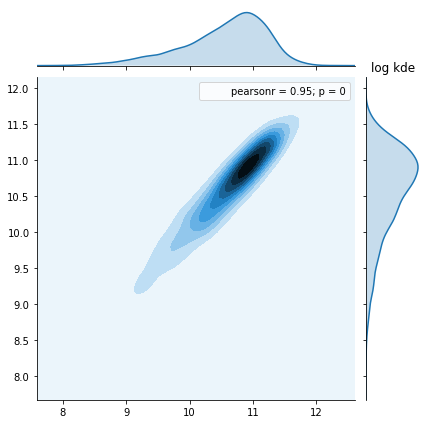

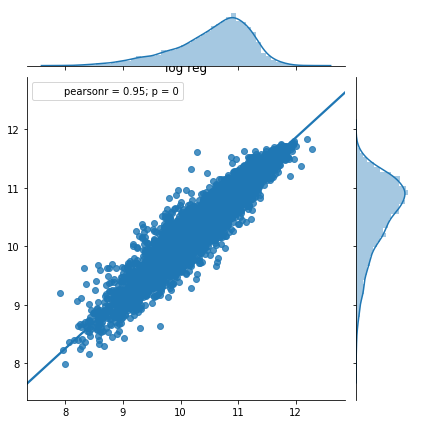

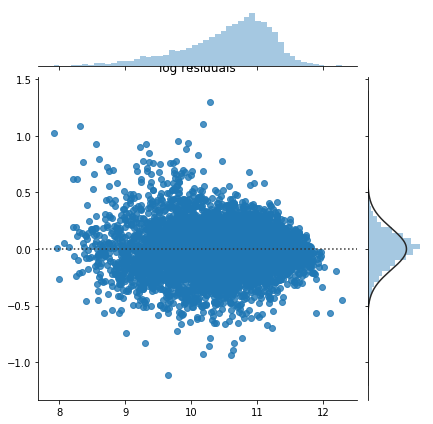

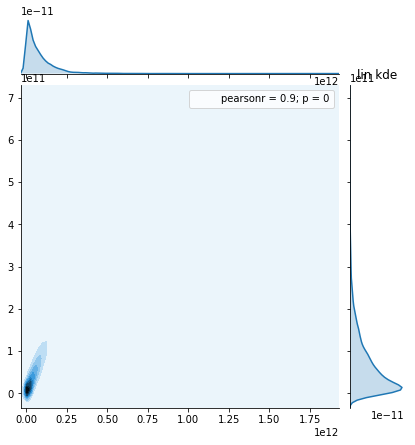

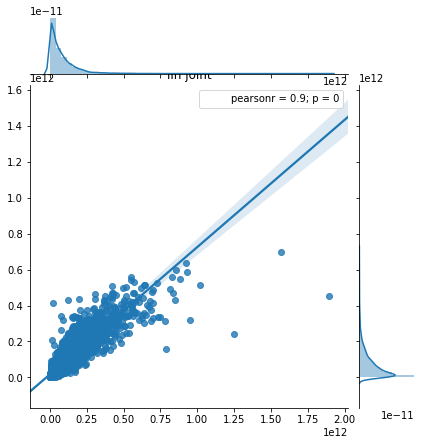

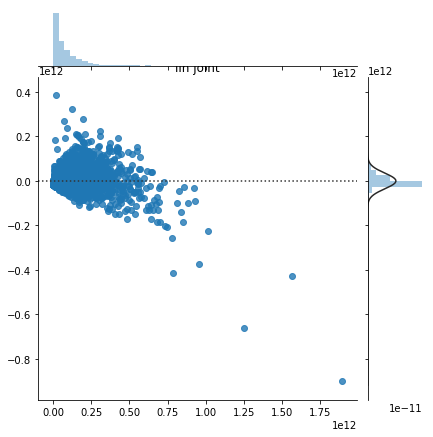

In [52]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
plt.title('log kde')
sns.jointplot(x=Y[M:], y=pred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y[M:], y=pred, kind='resid')
plt.title('log residuals')


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
plt.title('lin kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='reg')
plt.title('lin joint')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='resid')
plt.title('lin joint')
# plt.scatter(x=10**Y[M:], y=10**pred)
